# Adversarial training


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-deepmind/optax/blob/main/examples/adversarial_training.ipynb)

The following code trains a convolutional neural network (CNN) to be robust
with respect to the projected gradient descent (PGD) method.

The Projected Gradient Descent Method (PGD) is a simple yet effective method to
generate adversarial images. At each iteration, it adds a small perturbation
in the direction of the sign of the gradient with respect to the input followed
by a projection onto the infinity ball. The gradient sign ensures this
perturbation locally maximizes the objective, while the projection ensures this
perturbation stays on the boundary of the infinity ball.

## References

  Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining
  and harnessing adversarial examples.", https://arxiv.org/abs/1412.6572

  Madry, Aleksander, et al. "Towards deep learning models resistant to
  adversarial attacks.", https://arxiv.org/abs/1706.06083


To run the colab locally you need install the
`tensorflow-datasets`, `grain` packages via `pip`.

In [1]:
import datetime

import jax
from jax import numpy as jnp
from flax import linen as nn

import optax
from optax.losses import softmax_cross_entropy_with_integer_labels
from optax.tree_utils import tree_norm

from matplotlib import pyplot as plt
plt.rcParams.update({"font.size": 22})

import tensorflow_datasets as tfds
import grain

# Show on which platform JAX is running.
print("JAX running on", jax.devices()[0].platform.upper())

JAX running on GPU


In [2]:
# @markdown Total number of epochs to train for:
EPOCHS = 10  # @param{type:"integer"}
# @markdown Number of samples for each batch in the training set:
TRAIN_BATCH_SIZE = 128  # @param{type:"integer"}
# @markdown Number of samples for each batch in the test set:
TEST_BATCH_SIZE = 128  # @param{type:"integer"}
# @markdown Learning rate for the optimizer:
LEARNING_RATE = 0.001  # @param{type:"number"}
# @markdown The dataset to use.
DATASET = "mnist"  # @param{type:"string"}
# @markdown The amount of L2 regularization to use:
L2_REG = 0.0001  # @param{type:"number"}
# @markdown Adversarial perturbations lie within the infinity-ball of radius epsilon.
EPSILON = 0.01  # @param{type:"number"}

In [3]:
class CNN(nn.Module):
  """A simple CNN model."""
  num_classes: int

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=self.num_classes)(x)
    return x

In [4]:
train_source, test_source = tfds.data_source("mnist", split=["train", "test"])

train_loader_batched = (
    grain.MapDataset.source(train_source)
    .shuffle(seed=45)
    .map(lambda x: (x["image"], x["label"]))
    .batch(TRAIN_BATCH_SIZE, drop_remainder=True)
)
test_loader_batched = (
    grain.MapDataset.source(test_source)
    .map(lambda x: (x["image"], x["label"]))
    .batch(TEST_BATCH_SIZE, drop_remainder=True)
)

input_shape = (1, *train_source.dataset_info.features["image"].shape)
num_classes = train_source.dataset_info.features["label"].num_classes
iter_per_epoch_train = len(train_loader_batched)
iter_per_epoch_test = len(test_loader_batched)

In [5]:
net = CNN(num_classes)

@jax.jit
def accuracy(params, data):
  inputs, labels = data
  logits = net.apply({"params": params}, inputs)
  return jnp.mean(jnp.argmax(logits, axis=-1) == labels)


@jax.jit
def loss_fun(params, l2reg, data):
  """Compute the loss of the network."""
  inputs, labels = data
  x = inputs.astype(jnp.float32)
  logits = net.apply({"params": params}, x)
  sqnorm = tree_norm(params, squared=True)
  loss_value = jnp.mean(softmax_cross_entropy_with_integer_labels(logits, labels))
  return loss_value + 0.5 * l2reg * sqnorm

@jax.jit
def pgd_attack(image, label, params, epsilon=0.1, maxiter=10):
  """PGD attack on the L-infinity ball with radius epsilon.

  Args:
    image: array-like, input data for the CNN
    label: integer, class label corresponding to image
    params: tree, parameters of the model to attack
    epsilon: float, radius of the L-infinity ball.
    maxiter: int, number of iterations of this algorithm.

  Returns:
    perturbed_image: Adversarial image on the boundary of the L-infinity ball
      of radius epsilon and centered at image.

  Notes:
    PGD attack is described in (Madry et al. 2017),
    https://arxiv.org/pdf/1706.06083.pdf
  """
  image_perturbation = jnp.zeros_like(image)
  def adversarial_loss(perturbation):
    return loss_fun(params, 0, (image + perturbation, label))

  grad_adversarial = jax.grad(adversarial_loss)
  for _ in range(maxiter):
    # compute gradient of the loss wrt to the image
    sign_grad = jnp.sign(grad_adversarial(image_perturbation))

    # heuristic step-size 2 eps / maxiter
    image_perturbation += (2 * epsilon / maxiter) * sign_grad
    # projection step onto the L-infinity ball centered at image
    image_perturbation = jnp.clip(image_perturbation, - epsilon, epsilon)

  # clip the image to ensure pixels are between 0 and 1
  return jnp.clip(image + image_perturbation, 0, 1)

In [6]:
def dataset_stats(params, data_loader, iter_per_epoch):
  """Computes accuracy on clean and adversarial images."""
  adversarial_accuracy = 0.
  clean_accuracy = 0.
  for batch in data_loader:
    images, labels = batch
    images = images.astype(jnp.float32) / 255
    clean_accuracy += jnp.mean(accuracy(params, (images, labels))) / iter_per_epoch
    adversarial_images = pgd_attack(images, labels, params, epsilon=EPSILON)
    adversarial_accuracy += jnp.mean(accuracy(params, (adversarial_images, labels))) / iter_per_epoch
  return {"adversarial accuracy": adversarial_accuracy, "accuracy": clean_accuracy}

@jax.jit
def train_step(params, opt_state, batch):
  images, labels = batch
  # convert images to float as attack requires to take gradients wrt to them
  images = images.astype(jnp.float32) / 255
  adversarial_images_train = pgd_attack(images, labels, params, epsilon=EPSILON)
  # train on adversarial images
  loss_grad_fun = jax.grad(loss_fun)
  grads = loss_grad_fun(params, L2_REG, (adversarial_images_train, labels))
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return params, opt_state

In [7]:
# Initialize parameters.
key = jax.random.PRNGKey(0)
var_params = net.init(key, jnp.zeros(input_shape))["params"]

# Initialize the optimizer.
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(var_params)

start = datetime.datetime.now().replace(microsecond=0)

accuracy_train = []
accuracy_test = []
adversarial_accuracy_train = []
adversarial_accuracy_test = []
for epoch in range(EPOCHS):
  for train_batch in train_loader_batched:
    var_params, opt_state = train_step(var_params, opt_state, train_batch)

  # compute train set accuracy, both on clean and adversarial images
  train_stats = dataset_stats(var_params, train_loader_batched, iter_per_epoch_train)
  accuracy_train.append(train_stats["accuracy"])
  adversarial_accuracy_train.append(train_stats["adversarial accuracy"])

  # compute test set accuracy, both on clean and adversarial images
  test_stats = dataset_stats(var_params, test_loader_batched, iter_per_epoch_test)
  accuracy_test.append(test_stats["accuracy"])
  adversarial_accuracy_test.append(test_stats["adversarial accuracy"])

  time_elapsed = (datetime.datetime.now().replace(microsecond=0) - start)
  print(f"Epoch {epoch} out of {EPOCHS}")
  print(f"Accuracy on train set: {accuracy_train[-1]:.3f}")
  print(f"Accuracy on test set: {accuracy_test[-1]:.3f}")
  print(f"Adversarial accuracy on train set: {adversarial_accuracy_train[-1]:.3f}")
  print(f"Adversarial accuracy on test set: {adversarial_accuracy_test[-1]:.3f}")
  print(f"Time elapsed: {time_elapsed}\n")

Epoch 0 out of 10
Accuracy on train set: 0.982
Accuracy on test set: 0.982
Adversarial accuracy on train set: 0.979
Adversarial accuracy on test set: 0.977
Time elapsed: 0:00:10

Epoch 1 out of 10
Accuracy on train set: 0.989
Accuracy on test set: 0.987
Adversarial accuracy on train set: 0.986
Adversarial accuracy on test set: 0.984
Time elapsed: 0:00:15

Epoch 2 out of 10
Accuracy on train set: 0.991
Accuracy on test set: 0.988
Adversarial accuracy on train set: 0.988
Adversarial accuracy on test set: 0.986
Time elapsed: 0:00:21

Epoch 3 out of 10
Accuracy on train set: 0.992
Accuracy on test set: 0.989
Adversarial accuracy on train set: 0.990
Adversarial accuracy on test set: 0.986
Time elapsed: 0:00:26

Epoch 4 out of 10
Accuracy on train set: 0.992
Accuracy on test set: 0.988
Adversarial accuracy on train set: 0.990
Adversarial accuracy on test set: 0.985
Time elapsed: 0:00:32

Epoch 5 out of 10
Accuracy on train set: 0.995
Accuracy on test set: 0.991
Adversarial accuracy on train 

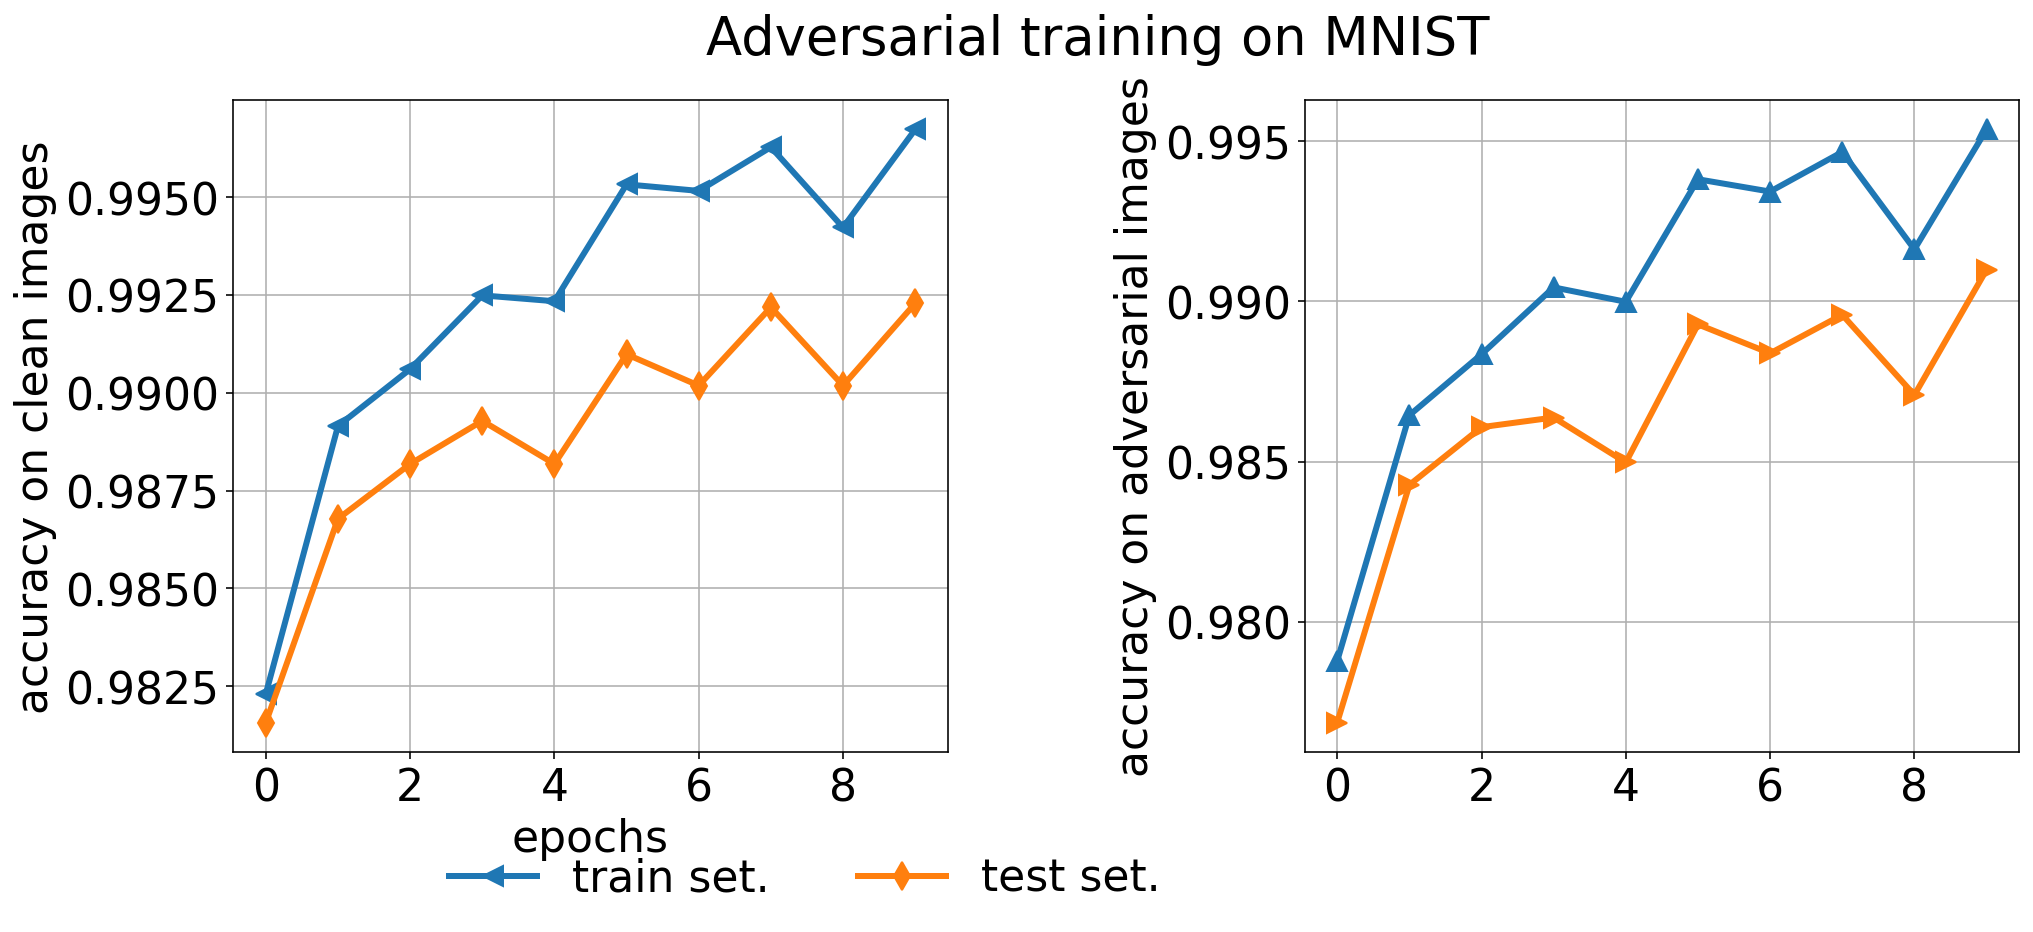

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plt.suptitle("Adversarial training on " + f"{DATASET}".upper())
axes[0].plot(
    accuracy_train, lw=3, label="train set.", marker="<", markersize=10
)
axes[0].plot(accuracy_test, lw=3, label="test set.", marker="d", markersize=10)
axes[0].grid()
axes[0].set_ylabel("accuracy on clean images")

axes[1].plot(
    adversarial_accuracy_train,
    lw=3,
    label="adversarial accuracy on train set.",
    marker="^",
    markersize=10,
)
axes[1].plot(
    adversarial_accuracy_test,
    lw=3,
    label="adversarial accuracy on test set.",
    marker=">",
    markersize=10,
)
axes[1].grid()
axes[0].legend(
    frameon=False, ncol=2, loc="upper center", bbox_to_anchor=(0.8, -0.1)
)
axes[0].set_xlabel("epochs")
axes[1].set_ylabel("accuracy on adversarial images")
plt.subplots_adjust(wspace=0.5)


plt.show()

Find a test set image that is correctly classified but not its adversarial perturbation

In [9]:
def find_adversarial_imgs(params, loader_batched):
  """Finds a test set image that is correctly classified but not its adversarial perturbation."""
  for batch in loader_batched:
    images, labels = batch
    images = images.astype(jnp.float32) / 255
    logits = net.apply({"params": params}, images)
    labels_clean = jnp.argmax(logits, axis=-1)

    adversarial_images = pgd_attack(images, labels, params, epsilon=EPSILON)
    labels_adversarial = jnp.argmax(
        net.apply({"params": params}, adversarial_images), axis=-1
    )
    idx_misclassified = jnp.where(labels_clean != labels_adversarial)[0]
    for j in idx_misclassified:
      clean_image = images[j]
      prediction_clean = labels_clean[j]
      if prediction_clean != labels[j]:
        # the clean image predicts the wrong label, skip
        continue
      adversarial_image = adversarial_images[j]
      adversarial_prediction = labels_adversarial[j]
      # we found our image
      return (
          clean_image,
          prediction_clean,
          adversarial_image,
          adversarial_prediction,
      )

  raise ValueError("No mismatch between clean and adversarial prediction found")


img_clean, pred_clean, img_adversarial, prediction_adversarial = (
    find_adversarial_imgs(var_params, test_loader_batched)
)

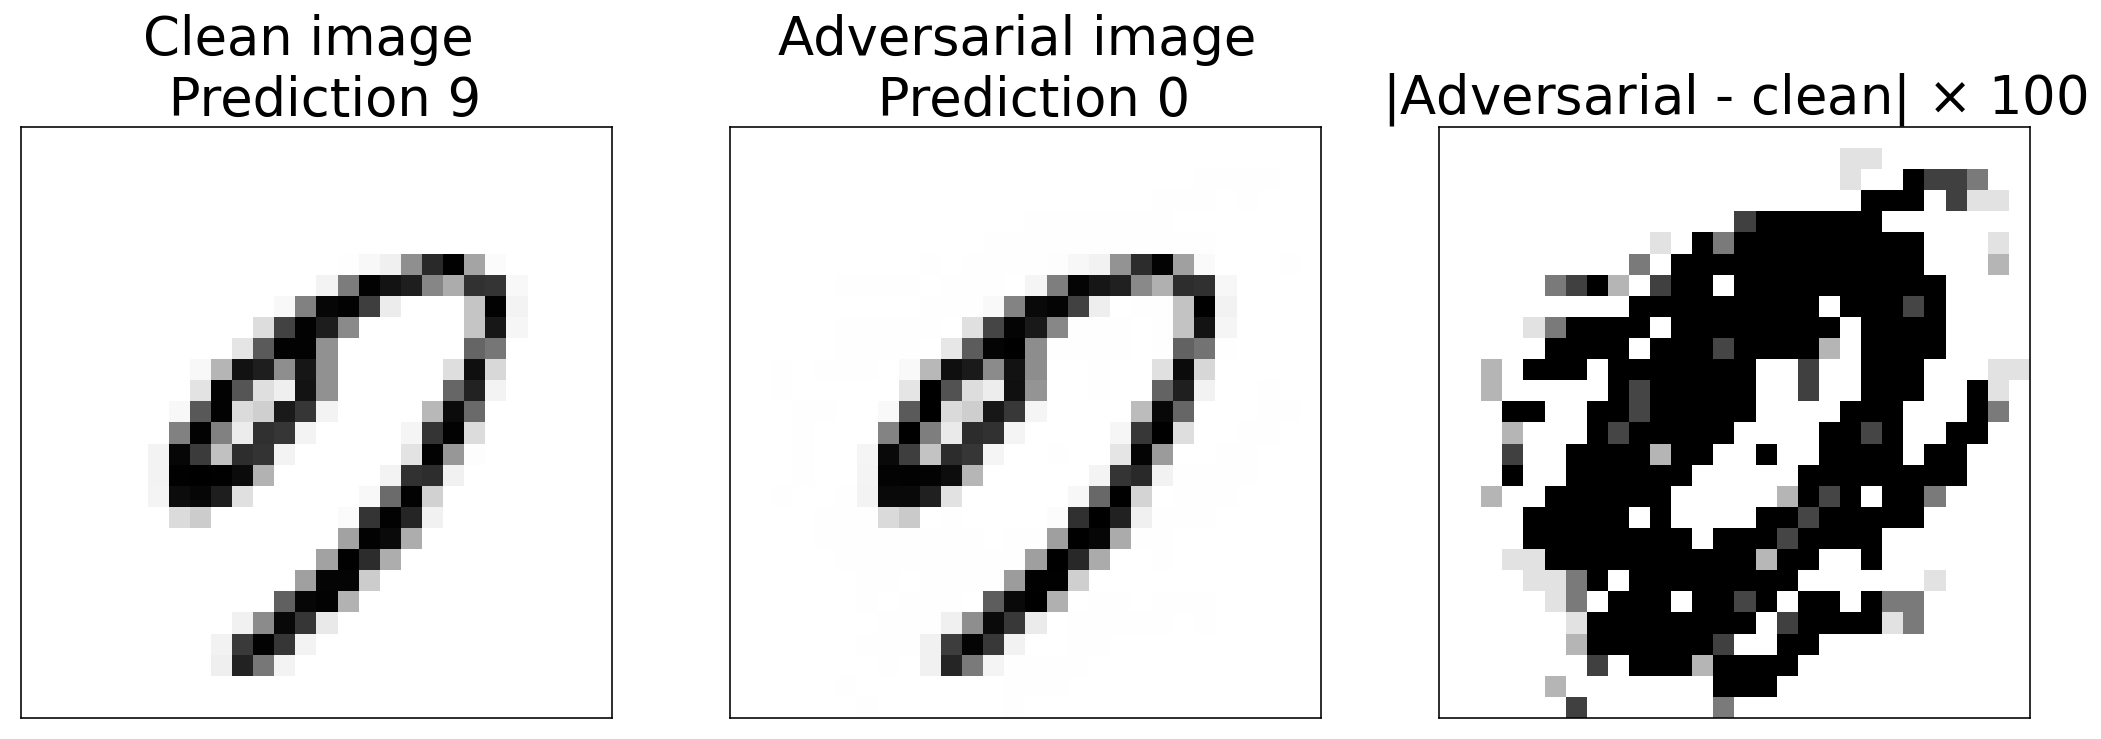

In [10]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(6 * 3, 6))

axes[0].set_title("Clean image \n Prediction %s" % int(pred_clean))
axes[0].imshow(img_clean, cmap=plt.cm.get_cmap("Greys"), vmax=1, vmin=0)
axes[1].set_title("Adversarial image \n Prediction %s" % prediction_adversarial)
axes[1].imshow(img_adversarial, cmap=plt.cm.get_cmap("Greys"), vmax=1, vmin=0)
axes[2].set_title(r"|Adversarial - clean| $\times$ %.0f" % (1 / EPSILON))
axes[2].imshow(
    jnp.abs(img_clean - img_adversarial) / EPSILON,
    cmap=plt.cm.get_cmap("Greys"),
    vmax=1,
    vmin=0,
)
for i in range(3):
  axes[i].set_xticks(())
  axes[i].set_yticks(())
plt.show()